<a href="https://colab.research.google.com/github/Ironsoldier353/QVI_Control_store/blob/main/Find_control_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('QVI_data.csv')

# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
# Extract month from DATE
df['MONTH'] = df['DATE'].dt.to_period('M')


In [4]:
print(df.columns)


Index(['LYLTY_CARD_NBR', 'DATE', 'STORE_NBR', 'TXN_ID', 'PROD_NBR',
       'PROD_NAME', 'PROD_QTY', 'TOT_SALES', 'PACK_SIZE', 'BRAND', 'LIFESTAGE',
       'PREMIUM_CUSTOMER', 'MONTH'],
      dtype='object')


Finding Control stores

In [14]:
from scipy.spatial.distance import euclidean

# Aggregate Data by Store
def aggregate_data(data):
    return data.groupby('STORE_NBR').agg({
        'TOT_SALES': 'sum',
        'LYLTY_CARD_NBR': 'nunique',
        'TXN_ID': 'count'
    }).rename(columns={
        'LYLTY_CARD_NBR': 'NUM_CUSTOMERS',
        'TXN_ID': 'NUM_TXNS'
    })

# Aggregate metrics for all stores
store_metrics = aggregate_data(df)

# Compute Similarity Scores
def compute_similarity(trial_stores, store_metrics):
    similarity_scores = []

    for trial_store in trial_stores:
        trial_store_data = store_metrics.loc[trial_store]

        for control_store in store_metrics.index:
            if control_store != trial_store:
                control_store_data = store_metrics.loc[control_store]

                # Calculate Euclidean distance
                distance = euclidean(trial_store_data, control_store_data)

                similarity_scores.append({
                    'trial_store': trial_store,
                    'control_store': control_store,
                    'distance': distance
                })

    return pd.DataFrame(similarity_scores)

# Define trial stores
trial_stores = [77, 86, 88]

# Compute similarity scores
similarity_scores = compute_similarity(trial_stores, store_metrics)

# Identify Top 3 Control Stores
def get_top_control_stores(similarity_scores, top_n=3):
    top_controls = {}

    for trial_store in trial_stores:
        top_controls[trial_store] = (
            similarity_scores[similarity_scores['trial_store'] == trial_store]
            .sort_values(by='distance')
            .head(top_n)['control_store']
            .tolist()
        )

    return top_controls

# Get top 3 control stores for each trial store
top_3_control_stores = get_top_control_stores(similarity_scores)

# Print the top control stores for each trial store
for trial_store, controls in top_3_control_stores.items():
    print(f"Trial Store {trial_store}: Top 3 Control Stores: {controls}")


Trial Store 77: Top 3 Control Stores: [50, 220, 46]
Trial Store 86: Top 3 Control Stores: [227, 155, 236]
Trial Store 88: Top 3 Control Stores: [165, 40, 237]


 Filter Data for Trial and Control Stores

In [17]:
def filter_store_data(df, stores):
    return df[df['STORE_NBR'].isin(stores)]

# List of trial stores
trial_stores = [77, 86, 88]

# Based on previous computation, the control stores identified (example)
top_3_control_stores = {
    77: [50, 46, 220],
    86: [227, 247, 155],
    88: [165, 40, 237]
}

# Flatten the list of control stores from the dictionary
control_stores = [store for stores in top_3_control_stores.values() for store in stores]

# Filter data for trial stores
trial_data = filter_store_data(df, trial_stores)

# Filter data for control stores
control_data = filter_store_data(df, control_stores)



Aggregate Data by Store

In [18]:
def aggregate_data(data):
    return data.groupby('STORE_NBR').agg({
        'TOT_SALES': 'sum',
        'LYLTY_CARD_NBR': 'nunique',
        'TXN_ID': 'count'
    }).rename(columns={
        'LYLTY_CARD_NBR': 'NUM_CUSTOMERS',
        'TXN_ID': 'NUM_TXNS'
    })

trial_agg = aggregate_data(trial_data)
control_agg = aggregate_data(control_data)


Compare Metrics between Trial and Control Stores

In [19]:
def compare_metrics(trial_agg, control_agg):
    comparison_results = []
    for trial_store in trial_agg.index:
        for control_store in control_agg.index:
            # Extract trial and control store data
            trial_store_data = trial_agg.loc[trial_store]
            control_store_data = control_agg.loc[control_store]

            # Calculate mean differences
            mean_diff_sales = trial_store_data['TOT_SALES'] - control_store_data['TOT_SALES']
            mean_diff_customers = trial_store_data['NUM_CUSTOMERS'] - control_store_data['NUM_CUSTOMERS']
            mean_diff_txns = trial_store_data['NUM_TXNS'] - control_store_data['NUM_TXNS']

            # Perform t-tests
            t_stat_sales, p_value_sales = stats.ttest_ind(
                trial_data[trial_data['STORE_NBR'] == trial_store]['TOT_SALES'],
                control_data[control_data['STORE_NBR'] == control_store]['TOT_SALES']
            )
            t_stat_customers, p_value_customers = stats.ttest_ind(
                trial_data[trial_data['STORE_NBR'] == trial_store]['LYLTY_CARD_NBR'],
                control_data[control_data['STORE_NBR'] == control_store]['LYLTY_CARD_NBR']
            )
            t_stat_txns, p_value_txns = stats.ttest_ind(
                trial_data[trial_data['STORE_NBR'] == trial_store]['TXN_ID'],
                control_data[control_data['STORE_NBR'] == control_store]['TXN_ID']
            )

            # Collect results
            comparison_results.append({
                'Comparison': f'Trial_{trial_store}_vs_Control_{control_store}',
                'mean_diff_sales': mean_diff_sales,
                'mean_diff_customers': mean_diff_customers,
                'mean_diff_txns': mean_diff_txns,
                't_stat_sales': t_stat_sales,
                'p_value_sales': p_value_sales,
                't_stat_customers': t_stat_customers,
                'p_value_customers': p_value_customers,
                't_stat_txns': t_stat_txns,
                'p_value_txns': p_value_txns
            })

    return pd.DataFrame(comparison_results)

# Perform comparisons
comparison_results = compare_metrics(trial_agg, control_agg)


 Check Statistical Significance

In [32]:
def check_significance(df):
    significant_results = df[
        (df['p_value_sales'] < 0.05) |
        (df['p_value_customers'] < 0.05) |
        (df['p_value_txns'] < 0.05)
    ]
    return significant_results

# Get significant results
significant_results = check_significance(comparison_results)


In [33]:
significant_results.to_csv('significant_results.csv', index=False)

In [34]:
top_3_control_stores = {
    77: [50, 46, 220],
    86: [227, 247, 155],
    88: [165, 40, 237]
}

# Create a DataFrame to store filtered results
filtered_results = pd.DataFrame()

for trial_store, top_controls in top_3_control_stores.items():
    for control_store in top_controls:
        result = comparison_results[
            (comparison_results['Comparison'] == f'Trial_{trial_store}_vs_Control_{control_store}')
        ]
        filtered_results = pd.concat([filtered_results, result])

Data Visualization

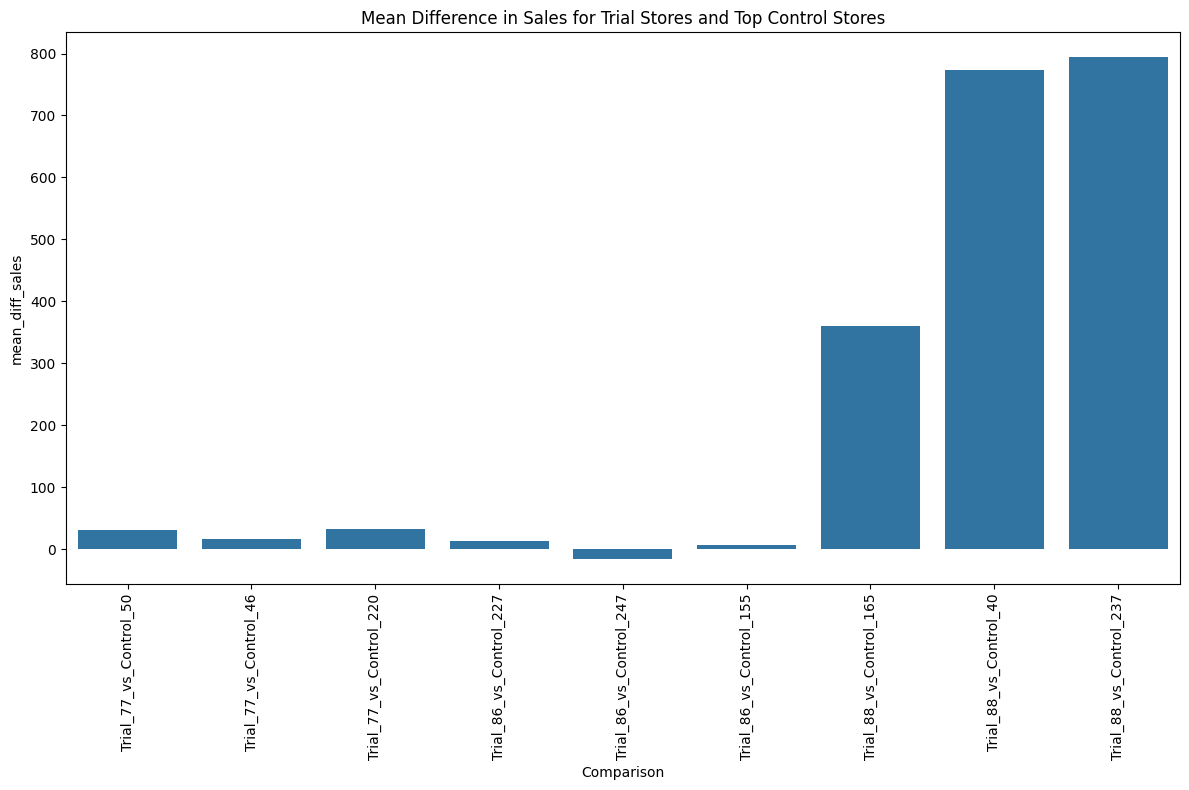

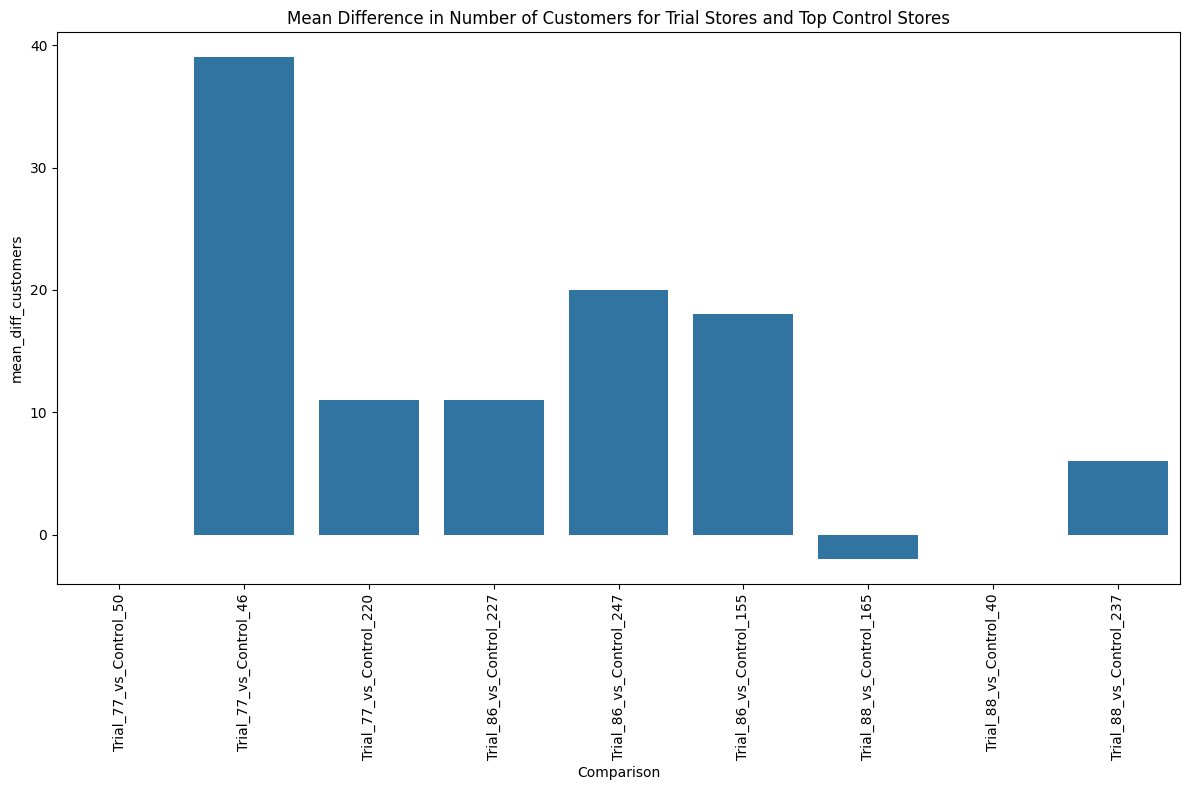

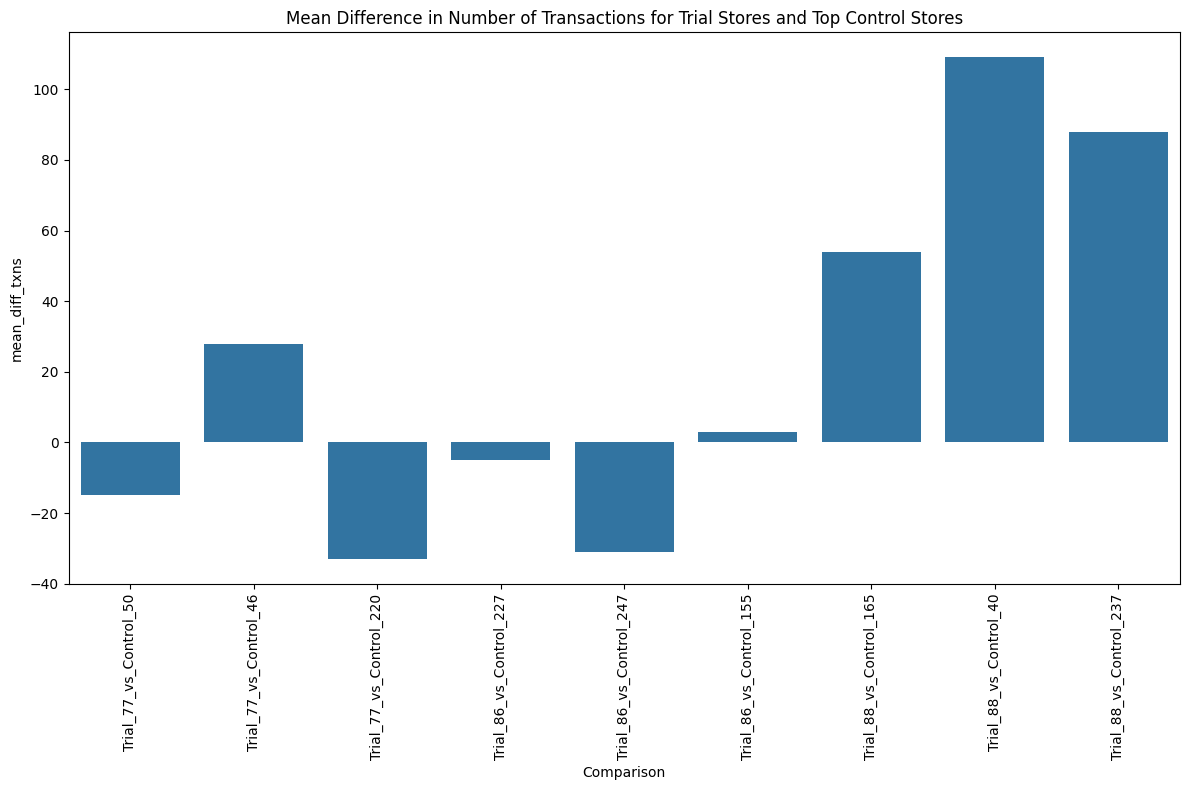

In [24]:
def plot_metrics(df, metric, title):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df, x='Comparison', y=metric)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison_filtered.png')
    plt.show()

# Plot filtered results
plot_metrics(filtered_results, 'mean_diff_sales', 'Mean Difference in Sales for Trial Stores and Top Control Stores')
plot_metrics(filtered_results, 'mean_diff_customers', 'Mean Difference in Number of Customers for Trial Stores and Top Control Stores')
plot_metrics(filtered_results, 'mean_diff_txns', 'Mean Difference in Number of Transactions for Trial Stores and Top Control Stores')


In [35]:
# Segment 8: Save Results to CSV
comparison_results.to_csv('comparison_results.csv', index=False)
significant_results.to_csv('significant_results.csv', index=False)
